In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import holidays
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("data/raw/rdu_historical_2024-08-16_to_2025-08-16.csv", parse_dates=['time'])
df = df.rename(columns={'time': 'datetime'})
df = df.sort_values('datetime').reset_index(drop=True)
df['temperature_2m'] = df['temperature_2m'].astype(float)

def feature_engineering(df):
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    df['temp_ma_6'] = df['temperature_2m'].rolling(window=6).mean()
    df['temp_ma_24'] = df['temperature_2m'].rolling(window=24).mean()
    df['temp_diff_1'] = df['temperature_2m'].diff(1)
    df['temp_diff_24'] = df['temperature_2m'].diff(24)
    
    df['day_max'] = df['temperature_2m'].rolling(24).max()
    df['day_min'] = df['temperature_2m'].rolling(24).min()
    df['day_range'] = df['day_max'] - df['day_min']
    
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    us_holidays = holidays.US(years=[2024,2025])
    df['is_holiday'] = df['datetime'].dt.date.isin(us_holidays).astype(int)

    
    df = df.dropna().reset_index(drop=True)
    return df

df = feature_engineering(df)

df_test = pd.read_csv("data/raw/rdu_test_set_2025-09-17_to_2025-09-30.csv", parse_dates=['time'])
df_test = df_test.rename(columns={'time': 'datetime'})
df_test = feature_engineering(df_test)


In [ ]:
feature_cols = [c for c in df.columns if c not in ['datetime', 'temperature_2m']]

feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df[feature_cols])

temp_scaler = MinMaxScaler()
scaled_temp = temp_scaler.fit_transform(df[['temperature_2m']])

X = np.hstack([scaled_features, scaled_temp])
y = scaled_temp


In [ ]:
scaled_features_test = feature_scaler.transform(df_test[feature_cols])
scaled_temp_test = temp_scaler.transform(df_test[['temperature_2m']])
X_test = np.hstack([scaled_features_test, scaled_temp_test])
y_test = scaled_temp_test

lookback = 168  
forecast_horizon = 24*14 
split_idx = int(len(X)*0.8)


In [6]:
class TempDataset(Dataset):
    def __init__(self, X, y, lookback, horizon, step=1):
        self.X, self.y = X, y
        self.lookback, self.horizon, self.step = lookback, horizon, step

    def __len__(self):
        return (len(self.X) - self.lookback - self.horizon) // self.step + 1

    def __getitem__(self, idx):
        idx = idx * self.step
        x_seq = self.X[idx:idx+self.lookback]
        y_seq = self.y[idx+self.lookback:idx+self.lookback+self.horizon]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [7]:
train_dataset = TempDataset(X[:split_idx], y[:split_idx], lookback, forecast_horizon, step=1)
val_dataset = TempDataset(X[split_idx:], y[split_idx:], lookback, forecast_horizon, step=1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [22]:
class EncoderDecoderLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_horizon):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.decoder = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_horizon)
    
    def forward(self, x):
        enc_out, (h, c) = self.encoder(x)
        enc_out = self.bn(enc_out[:, -1, :])
        enc_out = self.dropout(enc_out)
        dec_input = enc_out.unsqueeze(1).repeat(1, 1, 1)
        out, _ = self.decoder(dec_input)
        return self.fc(out[:, -1, :])

input_dim = X.shape[1]
model = EncoderDecoderLSTM(input_dim=input_dim, hidden_dim=64, output_horizon=forecast_horizon)
device = torch.device("cpu")
model.to(device)

EncoderDecoderLSTM(
  (encoder): LSTM(18, 64, batch_first=True, bidirectional=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decoder): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=336, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3  
)

In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        loss = criterion(preds, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = model(X_batch.to(device))
            val_loss += criterion(preds, y_batch.squeeze()).item()
    val_loss /= len(val_loader)
    
    cheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

Epoch 1/20, Train Loss: 0.0080, Val Loss: 0.0157, LR: 0.001000
Epoch 2/20, Train Loss: 0.0075, Val Loss: 0.0194, LR: 0.001000
Epoch 3/20, Train Loss: 0.0073, Val Loss: 0.0158, LR: 0.001000
Epoch 4/20, Train Loss: 0.0071, Val Loss: 0.0171, LR: 0.001000
Epoch 5/20, Train Loss: 0.0067, Val Loss: 0.0135, LR: 0.001000
Epoch 6/20, Train Loss: 0.0065, Val Loss: 0.0145, LR: 0.001000
Epoch 7/20, Train Loss: 0.0062, Val Loss: 0.0142, LR: 0.001000
Epoch 8/20, Train Loss: 0.0060, Val Loss: 0.0156, LR: 0.001000
Epoch 9/20, Train Loss: 0.0059, Val Loss: 0.0154, LR: 0.000500
Epoch 10/20, Train Loss: 0.0054, Val Loss: 0.0138, LR: 0.000500
Epoch 11/20, Train Loss: 0.0052, Val Loss: 0.0146, LR: 0.000500
Epoch 12/20, Train Loss: 0.0052, Val Loss: 0.0158, LR: 0.000500
Epoch 13/20, Train Loss: 0.0050, Val Loss: 0.0150, LR: 0.000250
Epoch 14/20, Train Loss: 0.0049, Val Loss: 0.0154, LR: 0.000250
Epoch 15/20, Train Loss: 0.0048, Val Loss: 0.0154, LR: 0.000250
Epoch 16/20, Train Loss: 0.0047, Val Loss: 0.0149

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true),1e-3)))) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

In [31]:
test_dataset = TempDataset(X_test, y_test, lookback, forecast_horizon, step=1)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch.to(device)).cpu().numpy()
        test_preds.append(preds)
        test_true.append(y_batch.numpy())

test_preds = np.concatenate(test_preds)
test_true = np.concatenate(test_true)

test_true_2d = test_true.reshape(-1, 1)
test_preds_2d = test_preds.reshape(-1, 1)

true_test_orig = temp_scaler.inverse_transform(test_true_2d).reshape(test_true.shape)
pred_test_orig = temp_scaler.inverse_transform(test_preds_2d).reshape(test_preds.shape)

mae, rmse, mape, r2 = regression_metrics(true_test_orig.flatten(), pred_test_orig.flatten())
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

Test MAE: 2.831, RMSE: 3.640, R²: 0.848


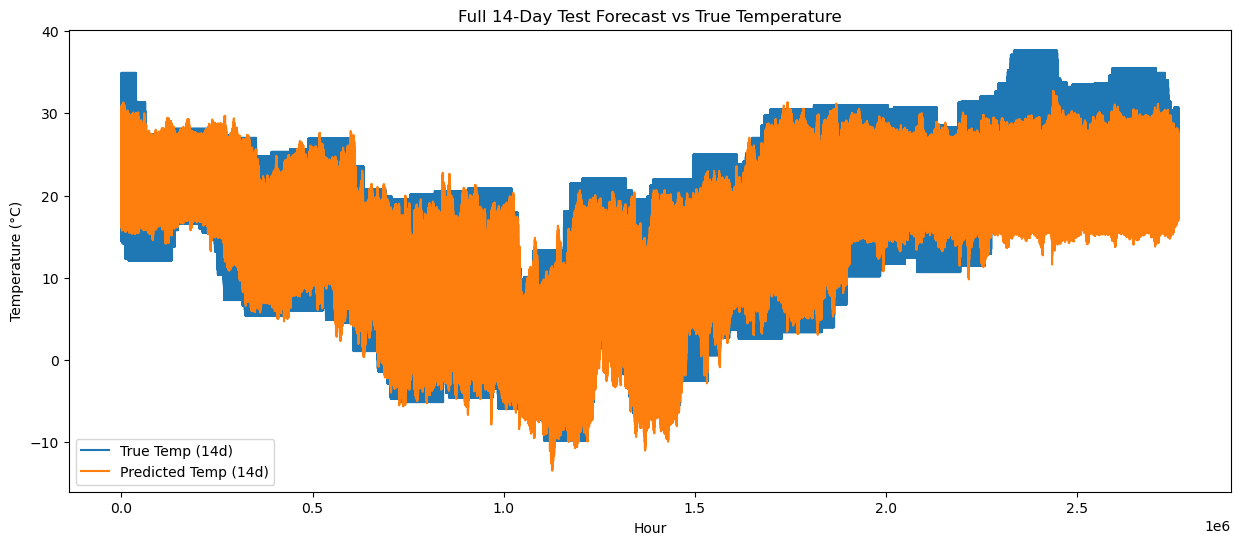

In [32]:
plt.figure(figsize=(15,6))
plt.plot(true_test_orig.flatten(), label="True Temp (14d)")
plt.plot(pred_test_orig.flatten(), label="Predicted Temp (14d)")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Full 14-Day Test Forecast vs True Temperature")
plt.show()